# TODOS (Design):

1. Create the list of functions
2. Generate the Clean and Dirty datasets
3. Train on Clean and Dirty datasets
4. Repeat (3) for different activation functions (Tanh, Sigmoid, ReLU, PReLU, etc...)
5. For each function, create a figure depicting each model's predictions vs the real value
6. Compare the figures from (5) to see which activation functions performed better

# Importing Packages

In [459]:
import numpy as np
import torch
import torchvision
import random
import math

import pandas as pd
from sklearn.model_selection import train_test_split

# Training
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Loading Data

In [460]:
config = {
    'epochs': 25,
    'batch_size': 128,
    'lr': 0.001,
    # 'weight_decay': 0,
    'weight_decay': 1e-5,
    'random_state': 182,
    'transform': torchvision.transforms.Compose([
            torchvision.transforms.Resize(64),
            torchvision.transforms.Normalize(mean=(0.0), std=(1.0))
        ]),
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(device)

device(type='cuda')

# Training

### The Datasets

In [461]:
class CleanDataset(Dataset):
    def __init__(self, df_x, df_y, mode):
        self.data = df_x.values
        img_shape = (int) (np.sqrt(self.data.shape[1]))
        self.data = torch.tensor(self.data.reshape(-1, 1, img_shape, img_shape), dtype=torch.float32)
        self.data = config['transform'](self.data)
        
        self.targets = torch.tensor(df_y.values, dtype=torch.long)
        
        self.dim = self.data.shape[1]
        print('Finished creating the CLEAN {} set of Dataset ({} samples found, each dim = {})'.format(mode, len(self.data), self.dim))
        print("\tdata.shape = ", self.data.shape, type(self.data))
        print("\ttargets.shape = ", self.targets.shape)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

In [462]:
class DirtyDataset(Dataset):
    def __init__(self, df_x, df_y, mode, dirty_frac=0.1):
        self.data = df_x.values
        img_shape = (int) (np.sqrt(self.data.shape[1]))
        self.data = torch.tensor(self.data.reshape(-1, 1, img_shape, img_shape), dtype=torch.float32)
        self.data = config['transform'](self.data)
        
        self.targets = torch.tensor(df_y.values, dtype=torch.long)
        
        if mode == 'train':
            for i in range(len(self.targets)):
                make_dirty = random.random()  # random float in [0, 1)
                if make_dirty > dirty_frac:
                    continue
                original = self.targets[i].clone()
                while self.targets[i] == original:
                    self.targets[i] = random.randrange(0, 10)
                # print(f"{original} ({type(original)}) -> {self.y[i]} ({type(self.y[i])})")
            
        self.dim = self.data.shape[1]
        print('Finished creating the DIRTY {} set of Dataset ({} samples found, each dim = {})'.format(mode, len(self.data), self.dim))
        print("\tdata.shape = ", self.data.shape)
        print("\ttarget.shape = ", self.targets.shape)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

### The Models

In [463]:
# TODO: Tune this modela architecture
class Net(nn.Module):
    def __init__(self, AF, num_classes=10):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5, stride=2, padding=0),
            nn.BatchNorm2d(10),
            AF(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            AF(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(24),
            AF(),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(24*7*7, 512),
            nn.BatchNorm1d(512),
            AF(),
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            AF(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(128, num_classes),
        )

        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

### Making a static Utility helper class

In [464]:
class Utility:
    # @staticmethod
    # def train(model, trainLoader, valLoader):
    #     model = model.to(device)
    #     optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    #     lr_scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
    #     acc_record = {'train': [], 'val': []}
    #     for epoch in range(config['epochs']):
    #         running_loss = 0.0
    #         running_correct = 0.0
    #         running_size = 0
    #         model.train()
    #         with tqdm(trainLoader, unit='batch') as tepoch:
    #             for (data, target) in tepoch:
    #                 tepoch.set_description("Epoch: {epoch:>2}".format(epoch=epoch+1))
    #                 data, target = data.to(device), target.to(device)

    #                 optimizer.zero_grad()
    #                 outputs = model(data)
    #                 loss = model.cal_loss(outputs, target)
    #                 loss.backward(inputs=list(model.parameters()))
    #                 optimizer.step()

    #                 # print statistics
    #                 running_loss += loss.item() * data.size(0)
    #                 running_size += data.size(0)
    #                 outputs = torch.argmax(outputs.detach(), dim=1)
    #                 assert outputs.shape==target.shape
    #                 running_correct += (target==outputs).sum().item()
    #                 tepoch.set_postfix(train="{acc:<.4f}".format(acc=100*running_correct/running_size))
    #                 acc_record['train'].append(running_correct/running_size)
            
    #         model.eval()
    #         correct = 0
    #         with torch.no_grad():
    #             for data, target in valLoader:
    #                 outputs = model(data.cuda()).cpu()
    #                 outputs = torch.argmax(outputs,dim=1)
    #                 correct += (outputs==target).sum().item()
    #         acc_record['val'].append(correct/len(valLoader.dataset))
    #         print("val={0:<12f}".format(100*correct/len(valLoader.dataset)))
    #         lr_scheduler.step()
    #     return acc_record
    

    @staticmethod
    def train(model, trainLoader, valLoader):
        model = model.to(device)
        best_val_acc = -1000
        optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        lr_scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
        acc_record = {'train': [], 'val': []}
        for epoch in range(config['epochs']):
            train_correct = 0
            model.train()
            for data, target in trainLoader:
                data, target = data.to(device), target.to(device)

                optimizer.zero_grad()
                outputs = model(data)
                loss = model.cal_loss(outputs, target)
                loss.backward(inputs=list(model.parameters()))
                optimizer.step()

                outputs = torch.argmax(outputs.detach(), dim=1)
                assert outputs.shape==target.shape
                train_correct += (outputs==target).sum().item()
            acc_record['train'].append(train_correct/len(trainLoader.dataset))
            
            model.eval()
            val_correct = 0
            with torch.no_grad():
                for data,target in valLoader:
                    outputs = model(data.cuda()).cpu()
                    outputs = torch.argmax(outputs, dim=1)
                    val_correct += (outputs==target).sum().item()
            acc_record['val'].append(val_correct/len(valLoader.dataset))
            # only print if the model improved
            if (val_correct/len(valLoader.dataset) > best_val_acc):
                print("\tEpoch {epoch:>2}: train={train:<12f} val={val:<12f}".format(
                    epoch=epoch+1, train=100*train_correct/len(trainLoader.dataset), val=100*val_correct/len(valLoader.dataset))
                )
                best_val_acc = val_correct/len(valLoader.dataset)
            lr_scheduler.step()
        return acc_record
            
    @staticmethod
    def plot_learning_curve(loss_record, title='', num_std_devs=3):
        ''' Plot learning curve of your DNN (train & dev loss) '''
        total_steps = len(loss_record['train'])
        x_1 = range(total_steps)
        offset = len(loss_record['train']) // len(loss_record['val'])
        x_2 = range(offset, total_steps + offset, offset)
        figure(figsize=(6, 4))
        plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
        plt.plot(x_2, loss_record['val'], c='tab:cyan', label='val')
        y_lim_low = min(np.mean(loss_record['train']) - num_std_devs * np.std(loss_record['train']), 
                        np.mean(loss_record['val']) - num_std_devs * np.std(loss_record['val']))
        y_lim_high = max(np.mean(loss_record['train']) + num_std_devs * np.std(loss_record['train']), 
                        np.mean(loss_record['val']) + num_std_devs * np.std(loss_record['val']))
        plt.ylim(y_lim_low, y_lim_high)
        plt.xlabel('Training steps')
        plt.ylabel('Accuracy')
        plt.title('Learning curve of {}'.format(title))
        plt.legend()
        plt.show()

    @staticmethod
    def plot_vals(clean, dirty, title='', num_std_devs=3):
        plt.plot(range(len(dirty)), dirty, label='dirty')
        plt.plot(range(len(clean)), clean, label='clean')
        y_lim_low = min(np.mean(clean) - num_std_devs * np.std(clean), 
                        np.mean(dirty) - num_std_devs * np.std(dirty))
        y_lim_high = max(np.mean(clean) + num_std_devs * np.std(clean), 
                        np.mean(dirty) + num_std_devs * np.std(dirty))
        plt.ylim(y_lim_low, y_lim_high)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Val Learning curve of {}'.format(title))
        plt.legend()
        plt.show()
            
    @staticmethod
    def plot_diff(diffs, labels, title='', num_std_devs=3):
        mins = []
        maxs = []
        for i in range(len(diffs)):
            plt.plot(range(len(diffs[i])), diffs[i], label=labels[i])
            mins.append(np.mean(diffs[i]) - num_std_devs * np.std(diffs[i]))
            maxs.append(np.mean(diffs[i]) + num_std_devs * np.std(diffs[i]))
        plt.ylim(min(mins), max(maxs))
        plt.xlabel('Training steps')
        plt.ylabel('Dirty Loss - Clean Loss')
        plt.title(title)
        plt.legend()
        plt.show()

    @staticmethod
    def list_diff(list1, list2):
        answer = []
        for i in range(len(list1)):
            answer.append(list1[i] - list2[i])
        return answer

### Defining the Comparator

In [465]:
# this class handles multiple models where their only difference is the activation function
class AFComparator():
    def __init__(self):
        self.AFs = {
            'ReLU': nn.ReLU,
            'Leaky ReLU': nn.LeakyReLU,
            'PReLU': nn.PReLU,
            'ELU': nn.ELU,
            'Sigmoid': nn.Sigmoid,
            'Tanh': nn.Tanh,
            'Softsign': nn.Softsign
        }
        self.cleanRecords = {}
        self.dirtyRecords = {}
        df_train = pd.read_csv("data/MNIST/train.csv")
        X, y = df_train.drop(columns='label'), df_train['label']
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=config['random_state'], stratify=y)
        # df_test = pd.read_csv("data/MNIST/test.csv")
        
        self.tr_set_clean = CleanDataset(X_train.copy(), y_train.copy(), mode='train')
        self.tr_set_dirty = DirtyDataset(X_train.copy(), y_train.copy(), mode='train')
        self.val_set = CleanDataset(X_val.copy(), y_val.copy(), mode='val')

        self.train_loader_clean = DataLoader(self.tr_set_clean, batch_size=config['batch_size'], shuffle=True)
        self.train_loader_dirty = DataLoader(self.tr_set_dirty, batch_size=config['batch_size'], shuffle=True)
        self.val_loader = DataLoader(self.val_set, batch_size=config['batch_size'], shuffle=False)

    def train_models(self):
        for i in range(len(self.AFs)):
            AFname, func = list(self.AFs.items())[i]
            print("=======================================")
            print(f"Training Clean Model with {AFname}")
            print("=======================================")
            clean_record = Utility.train(Net(func), self.train_loader_clean, self.val_loader)
            print("=======================================")
            print(f"Training Dirty Model with {AFname}")
            print("=======================================")
            dirty_record = Utility.train(Net(func), self.train_loader_dirty, self.val_loader)
            self.cleanRecords[AFname] = clean_record
            self.dirtyRecords[AFname] = dirty_record

    def plot_learning_curves(self):
        for i in range(len(self.cleanRecords)):
            AF_name = list(self.AFs.keys())[i]
            clean_record = self.cleanRecords[AF_name]
            dirty_record = self.dirtyRecords[AF_name]
            Utility.plot_learning_curve(clean_record, title=f"{AF_name} model (Clean)")
            Utility.plot_learning_curve(dirty_record, title=f"{AF_name} model (Dirty)")

    def plot_val_comparison(self):
        for i in range(len(self.cleanRecords)):
            AF_name = list(self.AFs.keys())[i]
            clean_record = self.cleanRecords[AF_name]
            dirty_record = self.dirtyRecords[AF_name]
            Utility.plot_vals(clean_record['val'], dirty_record['val'], title=f"Clean vs Dirty ({AF_name})")

    def plot_diff_curves(self):
        diffs = []
        labels = []
        for i in range(len(self.cleanRecords)):
            AF_name = list(self.AFs.keys())[i]
            clean_record = self.cleanRecords[AF_name]
            dirty_record = self.dirtyRecords[AF_name]
            diffs.append(Utility.list_diff(clean_record['val'], dirty_record['val']))
            labels.append(AF_name)
        Utility.plot_diff(diffs, labels, title='(Clean - Dirty) Val Loss')

    def make_submission(self):
        pass

In [466]:
comparator = AFComparator()

Finished creating the CLEAN train set of Dataset (31500 samples found, each dim = 1)
	data.shape =  torch.Size([31500, 1, 64, 64]) <class 'torch.Tensor'>
	targets.shape =  torch.Size([31500])
Finished creating the DIRTY train set of Dataset (31500 samples found, each dim = 1)
	data.shape =  torch.Size([31500, 1, 64, 64])
	target.shape =  torch.Size([31500])
Finished creating the CLEAN val set of Dataset (10500 samples found, each dim = 1)
	data.shape =  torch.Size([10500, 1, 64, 64]) <class 'torch.Tensor'>
	targets.shape =  torch.Size([10500])


In [467]:
comparator.train_models()

Training Clean Model with ReLU
	Epoch  1: train=91.409524    val=98.095238   
	Epoch  2: train=98.069841    val=98.438095   
	Epoch  3: train=98.577778    val=98.790476   
	Epoch  4: train=98.793651    val=98.876190   
	Epoch  5: train=98.888889    val=98.914286   
	Epoch  7: train=99.260317    val=99.019048   
	Epoch  8: train=99.260317    val=99.142857   
	Epoch  9: train=99.301587    val=99.161905   
	Epoch 19: train=99.590476    val=99.171429   
	Epoch 20: train=99.653968    val=99.190476   
	Epoch 21: train=99.701587    val=99.200000   
Training Dirty Model with ReLU
	Epoch  1: train=81.317460    val=97.780952   
	Epoch  2: train=88.234921    val=98.161905   
	Epoch  3: train=88.609524    val=98.609524   
	Epoch  5: train=89.019048    val=98.809524   
	Epoch  6: train=89.123810    val=98.838095   
	Epoch  7: train=89.231746    val=98.980952   
	Epoch 12: train=89.565079    val=98.990476   
	Epoch 20: train=89.739683    val=99.028571   
	Epoch 21: train=89.768254    val=99.047619  

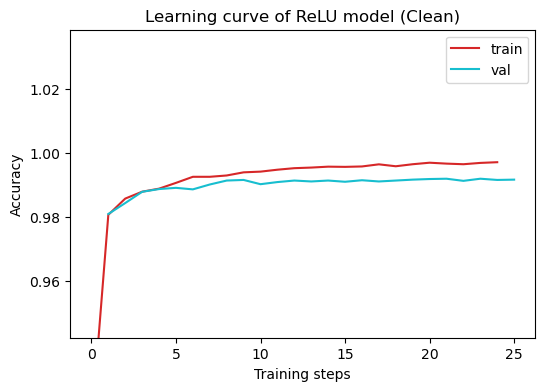

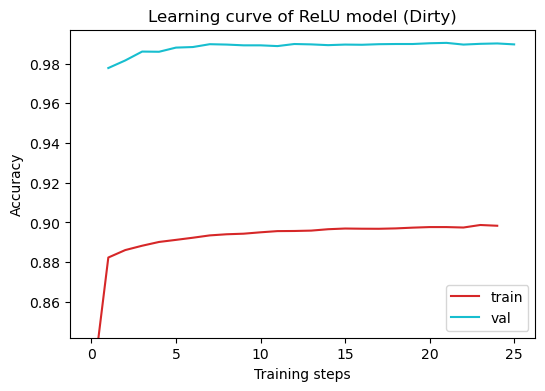

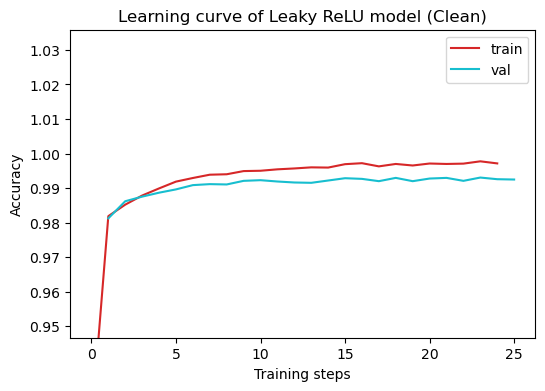

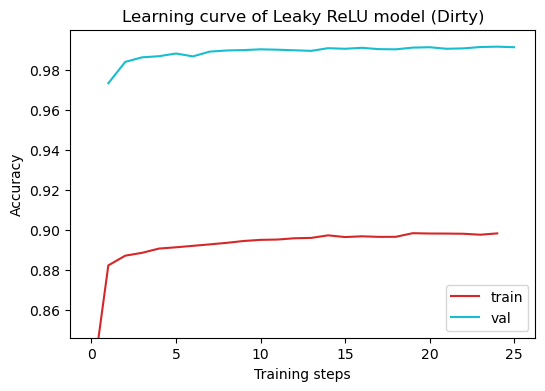

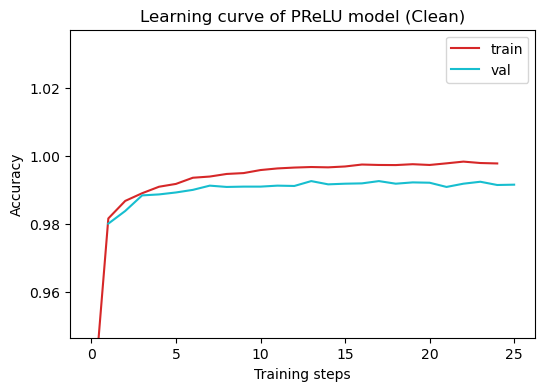

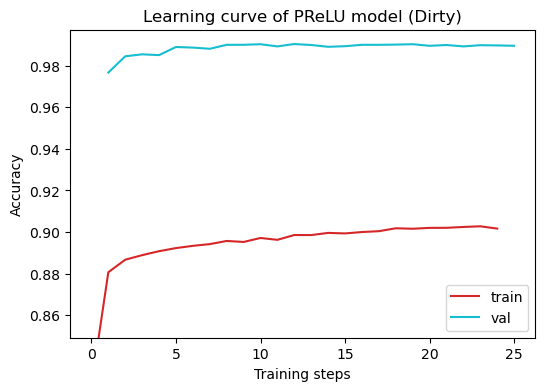

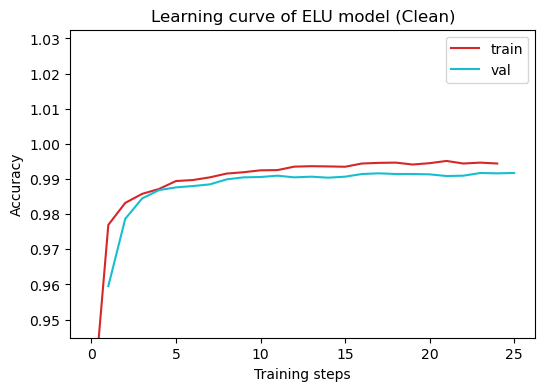

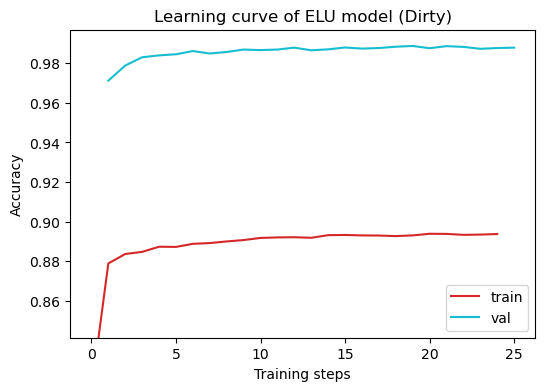

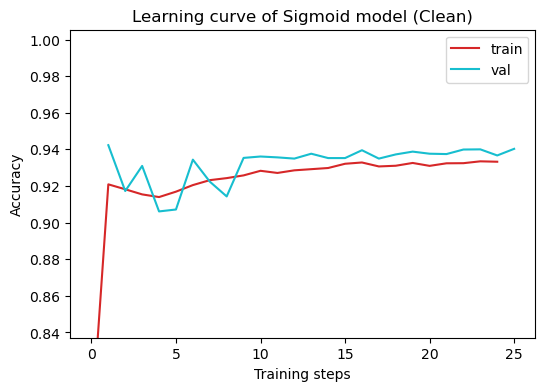

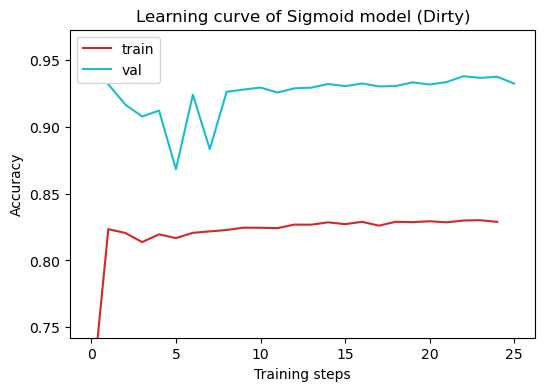

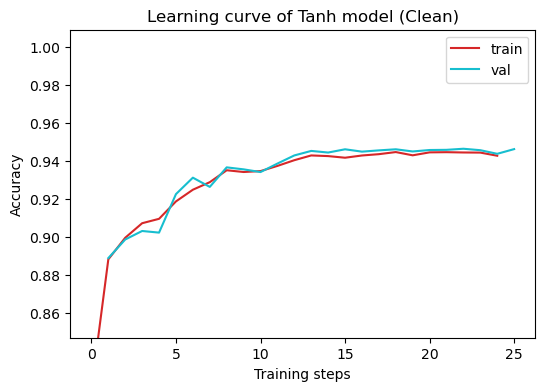

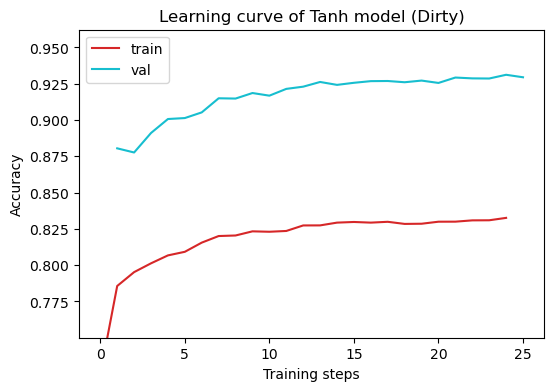

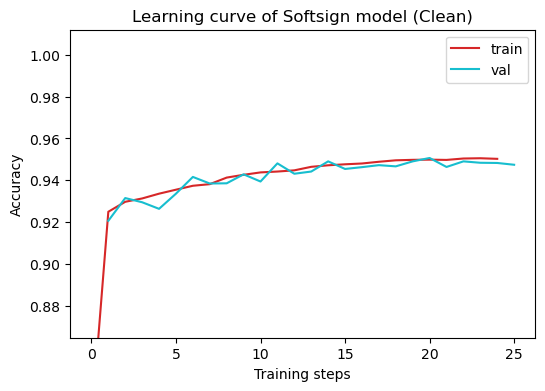

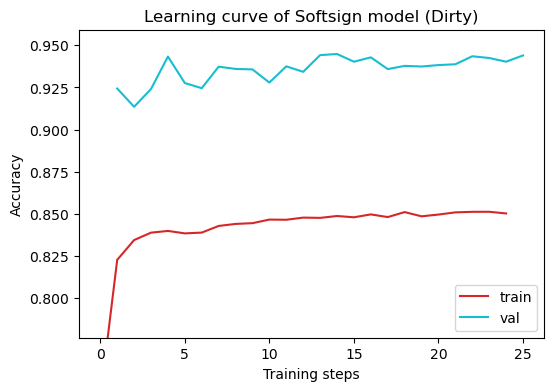

In [468]:
comparator.plot_learning_curves()

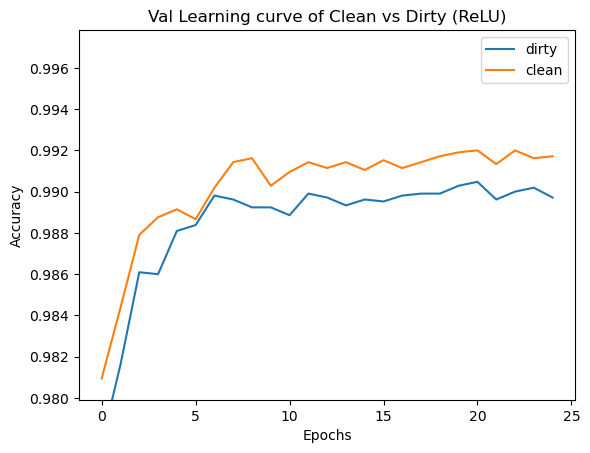

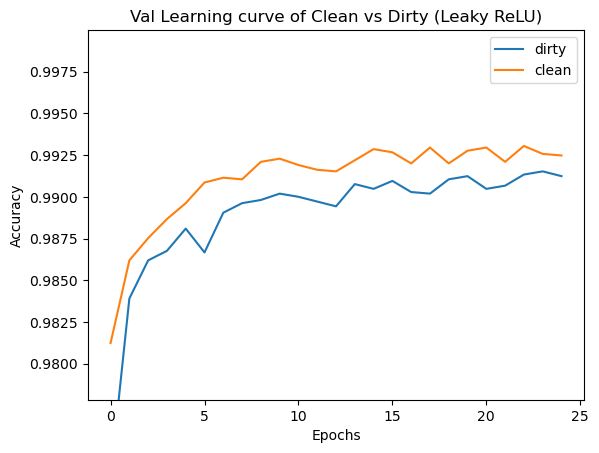

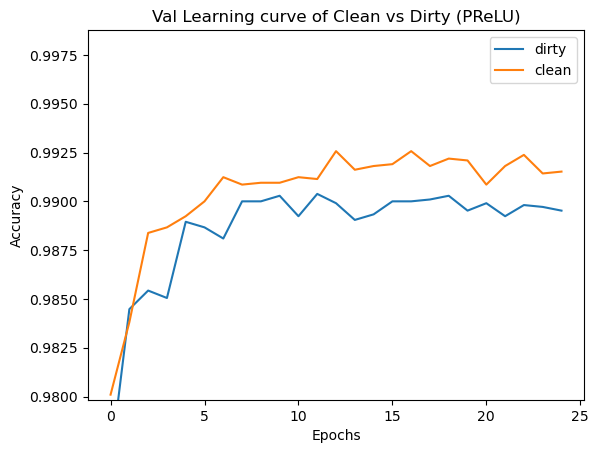

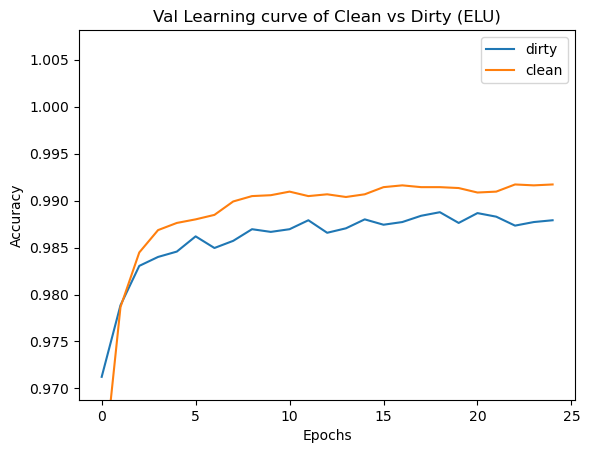

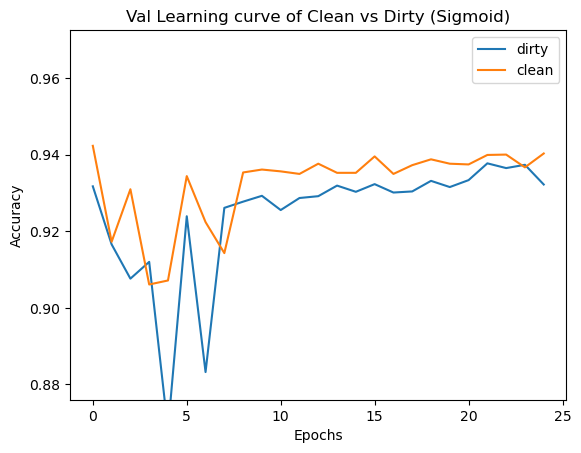

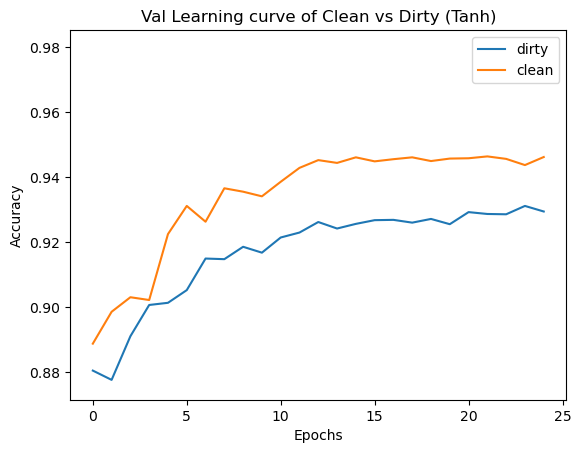

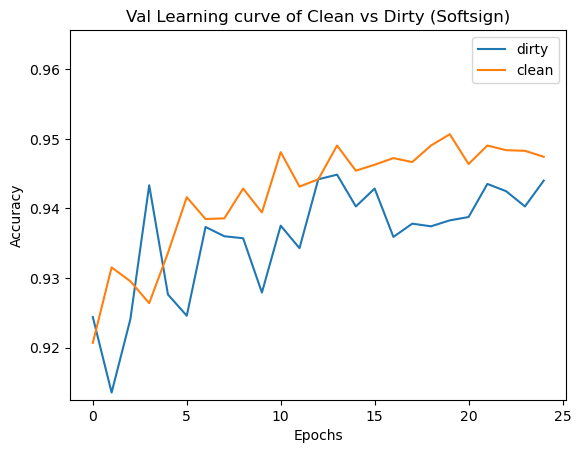

In [469]:
comparator.plot_val_comparison()

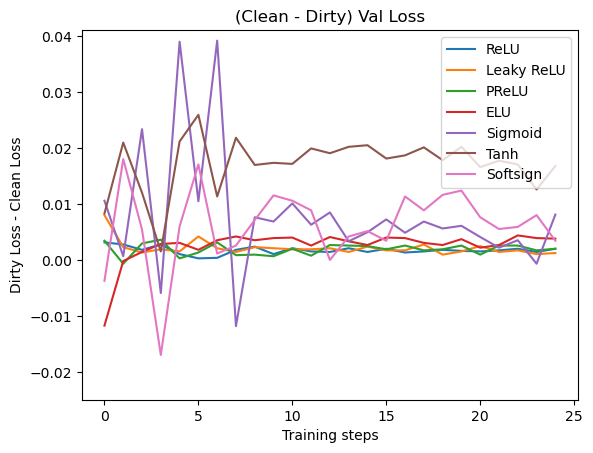

In [470]:
comparator.plot_diff_curves()